# **Single-Cell RNA-Seq Analysis: Variational Autoencoder and ResNet-Based Classification**

## **1. Introduction**

This project focuses on analyzing single-cell RNA sequencing (scRNA-seq) data from peripheral blood mononuclear cells (PBMCs). The goal is to classify cell types using a Variational Autoencoder (VAE) for dimensionality reduction and a ResNet-based Multi-Layer Perceptron (MLP) for classification. The VAE is designed to capture the underlying structure of the gene expression data, while the ResNet-based MLP is used to predict cell types based on the reduced-dimensional representation.

In [ ]:
# Import packages
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Deep Learning and Tensor Operations
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality Reduction and Clustering
import umap
from sklearn.cluster import KMeans

# Model Evaluation and Metrics
from sklearn.metrics import adjusted_rand_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Data Preprocessing and Splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Miscellaneous
import io
import sys

## **2. Data Preprocessing**

### **2.1 Data Loading and Exploration**
- The dataset is loaded from a CSV file containing gene expression data and cell type labels.
- The dataset dimensions and a random sample of 10 rows are displayed to understand its structure.

In [1]:
# Load data
file_path = './Project_2/data/Project_2_data.csv'
data = pd.read_csv(file_path)
data_df = pd.DataFrame(data)
# Display dataset dimensions and a random sample
print(data_df.head())

         Unnamed: 0   TNFRSF4    CPSF3L    ATAD3C   C1orf86      RER1  \
0  AAACATACAACCAC-1 -0.171470 -0.280812 -0.046677 -0.475169 -0.544024   
1  AAACATTGAGCTAC-1 -0.214582 -0.372653 -0.054804 -0.683391  0.633951   
2  AAACATTGATCAGC-1 -0.376888 -0.295085 -0.057527 -0.520972  1.332648   
3  AAACCGTGCTTCCG-1 -0.285241 -0.281735 -0.052227 -0.484929  1.572680   
4  AAACCGTGTATGCG-1 -0.256484 -0.220394 -0.046800 -0.345859 -0.333409   

   TNFRSF25   TNFRSF9  CTNNBIP1       SRM  ...     BACE2      SIK1  C21orf33  \
0  4.928497 -0.038028 -0.280573 -0.341788  ... -0.102943 -0.222116 -0.312401   
1 -0.334837 -0.045589 -0.498264 -0.541914  ...  0.007155 -0.445372  1.629285   
2 -0.309362 -0.103108 -0.272526 -0.500799  ... -0.071774 -0.297857 -0.410920   
3 -0.271825 -0.074552 -0.258875 -0.416752  ... -0.093818 -0.247770  2.552079   
4 -0.208122 -0.069514  5.806440 -0.283112  ... -0.167350 -0.098665 -0.275836   

     ICOSLG     SUMO3   SLC19A1     S100B     PRMT2  cell_type  \
0 -0.121678 -0

In [2]:
input_data = data.iloc[:, :-2]
print(input_data.head())

         Unnamed: 0   TNFRSF4    CPSF3L    ATAD3C   C1orf86      RER1  \
0  AAACATACAACCAC-1 -0.171470 -0.280812 -0.046677 -0.475169 -0.544024   
1  AAACATTGAGCTAC-1 -0.214582 -0.372653 -0.054804 -0.683391  0.633951   
2  AAACATTGATCAGC-1 -0.376888 -0.295085 -0.057527 -0.520972  1.332648   
3  AAACCGTGCTTCCG-1 -0.285241 -0.281735 -0.052227 -0.484929  1.572680   
4  AAACCGTGTATGCG-1 -0.256484 -0.220394 -0.046800 -0.345859 -0.333409   

   TNFRSF25   TNFRSF9  CTNNBIP1       SRM  ...     DSCR3     BRWD1     BACE2  \
0  4.928497 -0.038028 -0.280573 -0.341788  ... -0.226570 -0.236269 -0.102943   
1 -0.334837 -0.045589 -0.498264 -0.541914  ... -0.317531  2.568868  0.007155   
2 -0.309362 -0.103108 -0.272526 -0.500799  ... -0.302938 -0.239801 -0.071774   
3 -0.271825 -0.074552 -0.258875 -0.416752  ... -0.262978 -0.231807 -0.093818   
4 -0.208122 -0.069514  5.806440 -0.283112  ... -0.202237 -0.176765 -0.167350   

       SIK1  C21orf33    ICOSLG     SUMO3   SLC19A1     S100B     PRMT2  
0 -0.2

In [3]:
print(type(input_data))

<class 'pandas.core.frame.DataFrame'>


In [4]:
input_data.set_index('Unnamed: 0', inplace=True)

### **2.2 Gene Mean-Variance Plot**
- A scatter plot of gene mean vs. variance is created to visualize the distribution of gene expression.
- The plot shows that the gene expression distribution is closer to a negative binomial distribution rather than a normal distribution.Therefore, when constructing the variation autoencoder model later, the decoder simulates the negative binomial distribution output, and the loss function uses KL divergence + maximum likelihood loss.

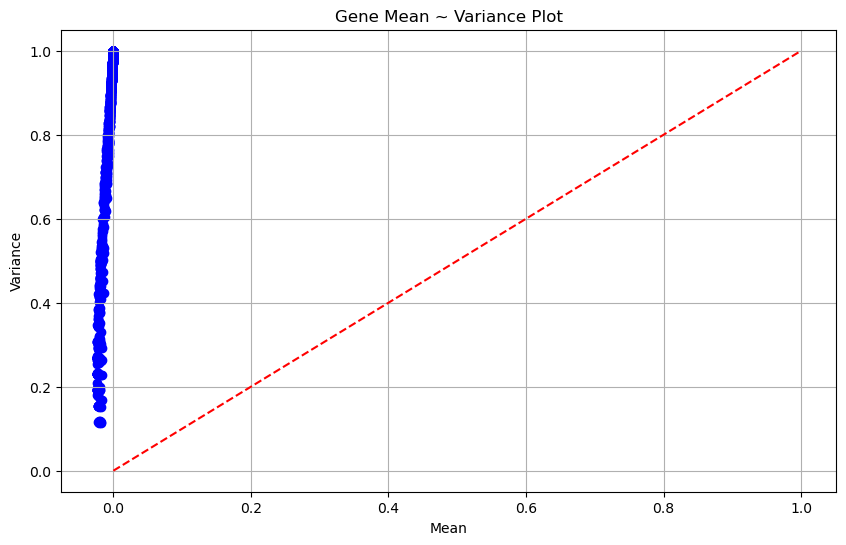

In [5]:
# Calculate mean and variance for each gene
mean_values = input_data.mean()
variance_values = input_data.var()
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(mean_values, variance_values, color='blue')
# Plot y=x line
max_value = max(mean_values.max(), variance_values.max())  
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='y=x')  
# Add labels and title
plt.title('Gene Mean ~ Variance Plot')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.grid()
plt.show()

## **3. Variational Autoencoder (VAE) for Dimensionality Reduction**

### **3.1 VAE Model Definition**
- The VAE model consists of an encoder and a decoder.
- The encoder compresses the input data into a latent space, while the decoder reconstructs the data from the latent space.
- The loss function combines KL divergence and negative binomial loss to handle the non-normal distribution of gene expression.

In [42]:
class scVI(nn.Module):
    def __init__(self, input_dim, latent_dim, drop_out_rate=0.1):
        super(scVI, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=drop_out_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=drop_out_rate),
            nn.BatchNorm1d(128),
            nn.Linear(128, 32),
            nn.ReLU(),
        )
        self.mu = nn.Linear(32, latent_dim)
        self.log_var = nn.Linear(32, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(p=drop_out_rate),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, input_dim),
        )
        
        # Parameters for Negative Binomial distribution
        self.alpha = nn.Parameter(torch.ones(input_dim))  # dispersion parameter (scale)
        self.beta = nn.Parameter(torch.ones(input_dim))   # rate parameter (mean)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + std * epsilon

    def decode(self, z):
        h = self.decoder(z)
        recon_x = torch.sigmoid(h)
        return recon_x

    def forward(self, x):
        # Encoding
        mu, log_var = self.encode(x)
        
        # Reparameterization trick to sample from the latent space
        z = self.reparameterize(mu, log_var)
        
        # Decoding
        recon_x = self.decode(z)
        
        # Return the output (reconstructed x) and latent variables for further computation
        return recon_x, mu, log_var

    def negative_binomial_loss(self, recon_x, x):
        epsilon = 1e-6  # Prevent numerical instability
        recon_x = torch.exp(recon_x)
        recon_x = torch.clamp(recon_x, min=1e-6, max=1e6)
        
        # Negative Binomial log-likelihood
        log_prob = -torch.lgamma(x + self.alpha) \
                + self.alpha * torch.log(self.beta + recon_x + epsilon) \
                - (self.alpha + x) * torch.log(self.beta + recon_x + epsilon)
                
        return -torch.sum(log_prob, dim=1).mean()

    def kl_divergence(self, mu, log_var):
        return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    def loss_function(self, recon_x, x, mu, log_var):
        recon_loss = self.negative_binomial_loss(recon_x, x)
        kl_loss = self.kl_divergence(mu, log_var)
        kl_weight = 0.5  # Adjust KL divergence weight
        loss = recon_loss + kl_weight * kl_loss
        return loss

### **3.2 Training the VAE Model**
- The VAE model is trained using the Adam optimizer.
- Early stopping is implemented to prevent overfitting based on the Adjusted Rand Index (ARI).

In [8]:
# Convert data to PyTorch tensor
input_array = input_data.values
data_tensor = torch.tensor(input_array, dtype=torch.float32)
print(data_tensor.shape)

torch.Size([2638, 1838])


In [31]:
# Create DataLoader
dataset = TensorDataset(data_tensor)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [43]:
# Initialize model and optimizer
genes_count = data_tensor.shape[1]
model = scVI(input_dim = genes_count, latent_dim = 50) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
num_epochs = 50

In [44]:
import umap
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [45]:
# Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_ari = -np.inf
        self.early_stop = False

    def __call__(self, ari_score):
        if ari_score > self.best_ari + self.delta:
            self.best_ari = ari_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

In [46]:
# Training loop
early_stopping = EarlyStopping(patience=3, delta=0.001)  
ari_scores = []  
best_ari_score = -float('inf')
best_umap1 = None  
best_umap2 = None
best_epoch = 0  

for epoch in range(num_epochs):
    for batch_idx, (data_batch,) in enumerate(dataloader):
        recon_x, mu, log_var = model(data_batch)  
        loss = model.loss_function(recon_x, data_batch, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
    
    # Evaluate ARI and UMAP        
    model.eval()
    with torch.no_grad():
        mu, log_var = model.encode(data_tensor)
        z = model.reparameterize(mu, log_var)
    umap_model = umap.UMAP(n_components=2)  
    z_umap = umap_model.fit_transform(z.numpy())  

    kmeans = KMeans(n_clusters=8, random_state=42)
    labels_pred = kmeans.fit_predict(z_umap)  

    labels = data.iloc[:, -2]
    ari_score = adjusted_rand_score(labels, labels_pred)

    if ari_score > best_ari_score:
        best_ari_score = ari_score
        best_umap1 = z_umap[:, 0]
        best_umap2 = z_umap[:, 1]
        best_epoch = epoch
    
    ari_scores.append(ari_score)

    if early_stopping(ari_score):
        print(f"Early stopping at epoch {epoch+1}")
        break  

Epoch [1/50], Batch [1/42], Loss: 626.9874
Epoch [1/50], Batch [11/42], Loss: 613.1303
Epoch [1/50], Batch [21/42], Loss: 596.6826
Epoch [1/50], Batch [31/42], Loss: 588.7054
Epoch [1/50], Batch [41/42], Loss: 611.1321
Epoch [2/50], Batch [1/42], Loss: 620.2471
Epoch [2/50], Batch [11/42], Loss: 556.1674
Epoch [2/50], Batch [21/42], Loss: 534.1662
Epoch [2/50], Batch [31/42], Loss: 528.2323
Epoch [2/50], Batch [41/42], Loss: 494.5596
Epoch [3/50], Batch [1/42], Loss: 463.6654
Epoch [3/50], Batch [11/42], Loss: 498.8972
Epoch [3/50], Batch [21/42], Loss: 455.1694
Epoch [3/50], Batch [31/42], Loss: 449.1829
Epoch [3/50], Batch [41/42], Loss: 450.6057
Epoch [4/50], Batch [1/42], Loss: 430.6093
Epoch [4/50], Batch [11/42], Loss: 419.7314
Epoch [4/50], Batch [21/42], Loss: 424.8539
Epoch [4/50], Batch [31/42], Loss: 391.7044
Epoch [4/50], Batch [41/42], Loss: 402.7745
Epoch [5/50], Batch [1/42], Loss: 376.4985
Epoch [5/50], Batch [11/42], Loss: 395.8926
Epoch [5/50], Batch [21/42], Loss: 37

### **3.3 Visualization of UMAP Projection**
- UMAP is used to visualize the latent space learned by the VAE.
- The UMAP plot shows the clustering of cell types in the latent space.

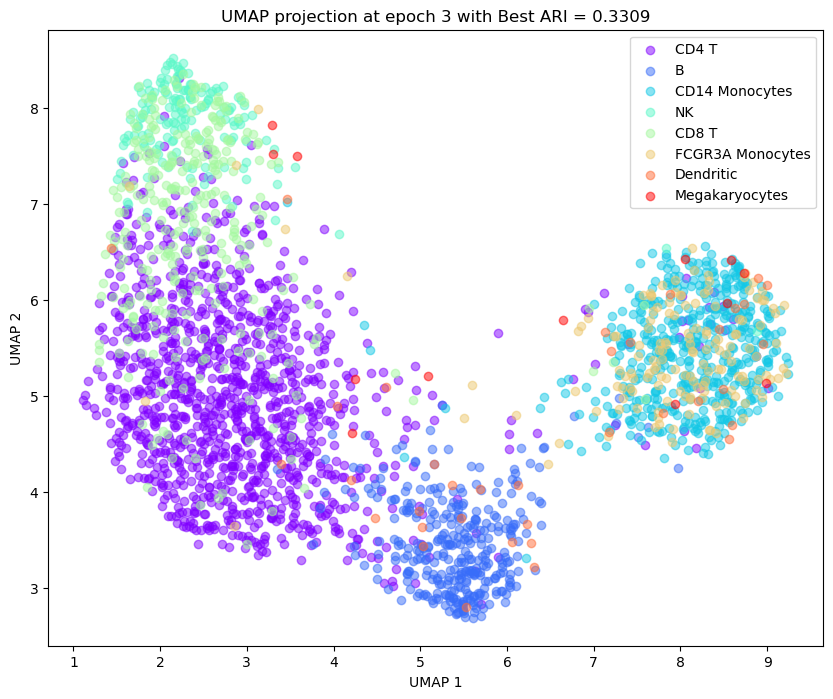

In [49]:
# Plot UMAP projection
best_umap = pd.DataFrame({'UMAP1': best_umap1, 'UMAP2': best_umap2})
best_umap['cell_type'] = data['cell_type']
best_umap['cell_type_string'] = data['cell_type_string']
unique_cell_types = best_umap['cell_type'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_cell_types)))
color_dict = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
plt.figure(figsize=(10, 8))
for cell_type in unique_cell_types:
    subset = best_umap[best_umap['cell_type'] == cell_type] 
    plt.scatter(subset['UMAP1'], subset['UMAP2'], c=[color_dict[cell_type]], label=subset['cell_type_string'].values[0], alpha=0.5)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f"UMAP projection at epoch {best_epoch+1} with Best ARI = {best_ari_score:.4f}")
plt.legend()
plt.show()

In [21]:
umap_model = umap.UMAP(n_components=2)  
original_umap = umap_model.fit_transform(input_data)  
kmeans = KMeans(n_clusters=8, random_state=42)
original_labels_pred = kmeans.fit_predict(original_umap)  
labels = data.iloc[:, -2]
original_ari_score = adjusted_rand_score(labels, original_labels_pred)
print(original_ari_score)

0.20979552224709627


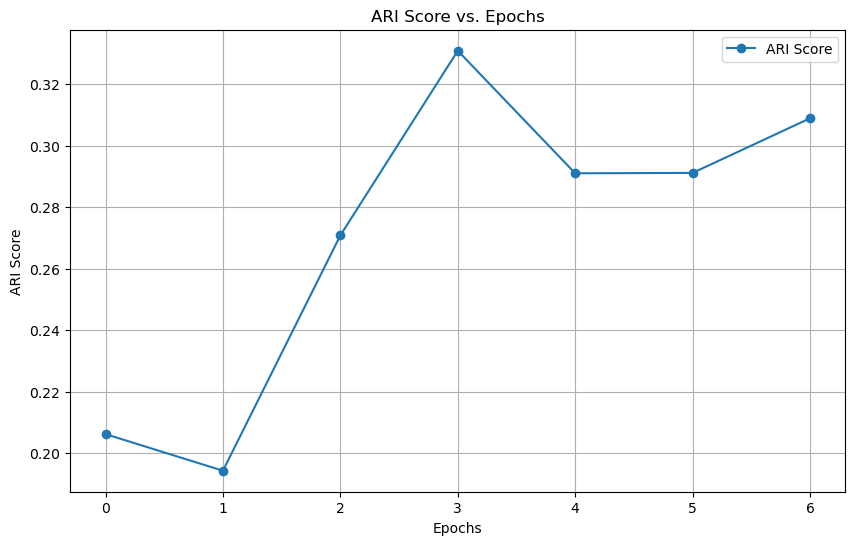

In [50]:
# Plot ARI Score vs Epochs
epochs = [0] + list(range(1, len(ari_scores) + 1))  
plt.figure(figsize=(10, 6))
plt.plot(epochs, [original_ari_score] + ari_scores, marker='o', label='ARI Score')  
plt.xlabel('Epochs')  
plt.ylabel('ARI Score')  
plt.title('ARI Score vs. Epochs') 
plt.grid(True)  
plt.legend()  
plt.xticks(epochs)  
plt.show()

In [28]:
models=[]
print(model) 

scVI(
  (encoder): Sequential(
    (0): Linear(in_features=1838, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=128, out_features=32, bias=True)
    (9): ReLU()
  )
  (mu): Linear(in_features=32, out_features=50, bias=True)
  (log_var): Linear(in_features=32, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, mome

In [ ]:
# Capturing print(model) Output
old_stdout = sys.stdout  # Save the current stdout
sys.stdout = io.StringIO()  # Replace with a StringIO object
print(model)
# Get the captured content and split it into lines
model_str = sys.stdout.getvalue().splitlines()
models.append(model_str)
# Restore stdout
sys.stdout = old_stdout
models.append(model_str)

## **4. Summary and Disscusion of VAE**

### **4.1. Model Architecture**

The Variational Autoencoder (VAE) model consists of two main components: an **encoder** and a **decoder**. The encoder compresses the input data into a lower-dimensional latent space, while the decoder reconstructs the data from this latent representation.

#### **4.1.1 Encoder**
The encoder takes the 1838-dimensional input data and compresses it into a 32-dimensional latent representation through three fully connected layers:
1. **First Layer**: Maps the input from 1838 dimensions to 256 dimensions, followed by ReLU activation, batch normalization, and dropout (dropout rate = 0.1).
2. **Second Layer**: Reduces the dimensionality from 256 to 128, followed by ReLU activation, dropout, and batch normalization.
3. **Third Layer**: Further compresses the data from 128 dimensions to 32 dimensions, followed by ReLU activation.

After these layers, the model uses two separate fully connected layers to output the mean (μ) and log variance (log_var) of the latent space, each with a dimensionality of 50.

#### **4.1.2 Decoder**
The decoder reconstructs the data from the 50-dimensional latent representation back to the original 1838 dimensions:
1. **First Layer**: Expands the latent space from 50 to 128 dimensions, followed by ReLU activation, batch normalization, and dropout.
2. **Second Layer**: Maps the 128-dimensional representation to 256 dimensions, followed by ReLU activation and batch normalization.
3. **Final Layer**: Reconstructs the 256-dimensional representation back to the original 1838 dimensions.

The entire model employs ReLU activation, batch normalization, dropout regularization (dropout rate = 0.1), and L2 regularization (weight decay = 0.01) between layers.

### **4.2. Key Insights and Observations**

#### **4.2.1 Importance of Batch Normalization**
Batch normalization is **critical** for stabilizing the model. Without it, the model produced NaN values in the reconstructed data (`recon_x`) and log probabilities (`log_prob`). Adjusting other hyperparameters did not resolve this issue, but adding batch normalization stabilized the training process.

#### **4.2.2 Latent Space Dimensionality**
The dimensionality of the latent space is a crucial hyperparameter. A range of 10 to 100 dimensions is recommended:
- **Too Small**: A latent space with insufficient dimensions may fail to capture the complexity of the data, leading to poor sample diversity.
- **Too Large**: A high-dimensional latent space may reduce the effectiveness of dimensionality reduction.

#### **4.2.3 KL Divergence Weight**
The weight of the KL divergence term in the loss function controls the strength of the constraint on the latent space to follow a normal distribution. This acts as a regularization term, preventing overfitting and maintaining sample diversity. However:
- **Low Weight**: Results in insufficient regularization, leading to poor clustering performance.
- **High Weight**: Causes the latent space to become overly constrained, resulting in less diverse samples and suboptimal clustering.

#### **4.2.4 Model Evaluation Using ARI**
The Adjusted Rand Index (ARI) was used to evaluate the clustering performance of the latent space. However, the ARI is highly sensitive to the number of clusters (`n_clusters`) in KMeans, raising questions about its reliability as an evaluation metric for the VAE model. Visualizations of the latent space revealed that:
- With a low KL divergence weight, the latent space was not well-regularized, leading to poor clustering.
- Increasing the KL divergence weight improved ARI scores but resulted in a more dispersed latent space, indicating a trade-off between regularization and sample diversity.

#### **4.2.5 Joint Loss Function**
The optimization objective of minimizing the loss function (reconstruction error + KL divergence) may not align with the goal of achieving good clustering performance (measured by ARI). To address this, a **joint loss function** could be designed to incorporate both reconstruction error and clustering-related loss (e.g., K-means clustering loss or density estimation loss). However, this approach may be specific to this task and may not generalize well to other applications.


### **4.3. Reference to scVI Model**
The model architecture is inspired by the scVI model proposed in the following paper:
- **Reference**: Lopez, R., Regier, J., Cole, M.B. et al. Deep generative modeling for single-cell transcriptomics. *Nature Methods* **15**, 1053–1058 (2018). [https://doi.org/10.1038/s41592-018-0229-2](https://doi.org/10.1038/s41592-018-0229-2)

#### **4.3.1 Limitations of scVI for This Dataset**
The scVI model requires raw single-cell RNA-seq data as input. However, the provided `pbmc.csv` dataset is preprocessed and normalized, making it unsuitable for direct use with scVI. As a result, the scVI-based dimensionality reduction process was not implemented in this project.

### **4.4. Discussion**

#### **4.4.1 Challenges in Model Design**
- **Trade-offs in Hyperparameters**: Balancing the latent space dimensionality, KL divergence weight, and regularization strength is challenging. These hyperparameters significantly impact both the model's performance and the quality of the latent space.
- **Evaluation Metrics**: The use of ARI as an evaluation metric may not fully capture the quality of the latent space, as it is sensitive to the number of clusters in KMeans. Alternative metrics or visualization techniques could be explored.

#### **4.2 Potential Improvements**
- **Joint Loss Function**: Incorporating a clustering-related loss into the VAE training process could improve the alignment between the optimization objective and clustering performance.
- **Advanced Regularization Techniques**: Techniques such as variational dropout or adversarial training could be explored to enhance the model's robustness and generalization ability.
- **Alternative Evaluation Metrics**: Metrics such as silhouette score or Davies-Bouldin index could be used alongside ARI to provide a more comprehensive evaluation of the latent space.

#### **4.4.3 Broader Implications**
While the proposed joint loss function and advanced regularization techniques may improve performance on this specific task, their applicability to other datasets and tasks remains to be validated. Future work should focus on developing more generalizable approaches for single-cell RNA-seq data analysis.

The VAE model successfully captures the underlying structure of the single-cell RNA-seq data, but careful tuning of hyperparameters and evaluation metrics is required to achieve optimal performance. The insights gained from this project highlight the importance of balancing regularization, latent space dimensionality, and clustering performance in deep generative models for single-cell data analysis. Future work should explore more robust evaluation methods and advanced regularization techniques to further improve the model's effectiveness.

In [ ]:
import scvi
import scanpy as sc

scvi_data = input_data.copy()  
scvi_data['cell_type'] = labels  
adata = sc.AnnData(scvi_data.iloc[:, :-1].values)  
adata.obs['cell_type'] = scvi_data['cell_type']
adata.var['gene_names'] = scvi_data.columns[:-1]  #
print(adata)

In [ ]:
scvi.model.SCVI.setup_anndata(adata)  
model = scvi.model.SCVI(adata)
model.train() 

In [ ]:
latent_representation = model.get_latents()  
print(latent_representation.shape)  

In [ ]:
scvi_umap = umap_model.fit_transform(latent_representation)
kmeans = KMeans(n_clusters=5, random_state=42)
scvi_labels_pred = kmeans.fit_predict(scvi_umap) 
labels = data.iloc[:, -2]
scvi_ari_score = adjusted_rand_score(labels, scvi_labels_pred)

In [ ]:
scvi_umap_df = pd.DataFrame({'UMAP1': scvi_umap[:, 0], 'UMAP2': scvi_umap[:, 1]})
scvi_umap_df['cell_type'] = data['cell_type']
scvi_umap_df['cell_type_string'] = data['cell_type_string']
plt.figure(figsize=(10, 8))
for cell_type in unique_cell_types:
    subset = scvi_umap_df[scvi_umap_df['cell_type'] == cell_type] 
    plt.scatter(subset['UMAP1'], subset['UMAP2'], c=[color_dict[cell_type]], label=subset['cell_type_string'].values[0], alpha=0.5)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title("UMAP projection of scVI latent space")
plt.legend()
plt.show()

## **5. ResNet-Based MLP for Cell Type Classification**

### **5.1 Data Preparation**
- The dataset is split into training, validation, and test sets.
- The labels are encoded as integers for classification.

In [ ]:
# Prepare input data
input_data = data.iloc[:, :-2]
input_data.set_index('Unnamed: 0', inplace=True)
X = input_data.values
y = data.iloc[:,-2].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### **5.2 ResNet-Based MLP Model**
- The ResNet-based MLP model consists of multiple ResNet blocks with residual connections.
- The model is trained using the Adam optimizer with L2 regularization.

In [ ]:
# Defining the ResNet Module
class ResNetBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.5):
        super(ResNetBlock, self).__init__()
        # First Layer
        self.fc1 = nn.Linear(input_size, output_size)
        self.bn1 = nn.BatchNorm1d(output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        
        # Second Layer
        self.fc2 = nn.Linear(output_size, output_size)
        self.bn2 = nn.BatchNorm1d(output_size)
        
        # Residual Connection
        self.shortcut = nn.Linear(input_size, output_size) if input_size != output_size else nn.Identity()

    def forward(self, x):
        # Residual Connection
        residual = self.shortcut(x)
        
        # First Layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Second Layer
        x = self.fc2(x)
        x = self.bn2(x)
        
        # Add Residual
        x += residual
        x = self.relu(x)
        return x

# Defining an MLP with ResNet Structure
class ResNetMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(ResNetMLP, self).__init__()
        
        # Building Layers of ResNet Blocks
        self.blocks = nn.ModuleList()
        in_size = input_size
        for hidden_size in hidden_sizes:
            self.blocks.append(ResNetBlock(in_size, hidden_size, dropout_prob))
            in_size = hidden_size
        
        # Final Output Layer
        self.fc_out = nn.Linear(in_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.fc_out(x)
        return self.softmax(x)

# Parameter Settings
input_size = X_train.shape[1]  # Number of features in gene expression data
hidden_sizes = [256, 128, 64]  # Number of neurons in each layer, different layers have different numbers of neurons
output_size = len(np.unique(y))  # Number of output cell types

# Initialize the Model
model = ResNetMLP(input_size, hidden_sizes, output_size, dropout_prob=0.5)

In [ ]:
# Converting Data to Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Setting the L2 Regularization Coefficient
l2_lambda = 0.01  # This is the L2 regularization coefficient
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()  # For multi-class problems, use the cross-entropy loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)   

In [ ]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
# Split data into training, validation, and test sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training the Model
epochs = 50
patience = 3  # Maximum number of epochs allowed without improvement in validation loss
best_val_loss = float('inf')  # Initialize best validation loss
counter = 0  # Counter for epochs without improvement in validation loss

# To save the loss for each epoch
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Accumulate training loss

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Accumulate loss for each batch

    # Calculate the average training loss
    avg_train_loss = running_loss / len(train_loader)

    # Calculate loss on the validation set
    model.eval()  # Set the model to evaluation mode, disable Dropout, etc.
    running_val_loss = 0.0  # Accumulate validation loss

    with torch.no_grad():  # Disable gradient calculation to save memory
        for inputs, targets in val_loader:
            val_outputs = model(inputs)
            val_loss = criterion(val_outputs, targets)
            running_val_loss += val_loss.item()

    # Calculate the average validation loss
    avg_val_loss = running_val_loss / len(val_loader)

    # Save the loss for each epoch
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Check if the validation loss has improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # Reset counter if loss improves
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')  # Save model parameters
        print(f"Saving best model with validation loss: {avg_val_loss:.4f}")
    else:
        counter += 1  # Increment counter if loss does not improve

    # Print training and validation losses
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # If validation loss does not improve for `patience` epochs, stop training
    if counter >= patience:
        print(f"Early stopping at epoch {epoch + 1} with validation loss {avg_val_loss:.4f}")
        break

Saving best model with validation loss: 1.5038
Saving best model with validation loss: 1.4581
Saving best model with validation loss: 1.4501
Early stopping at epoch 6 with validation loss 1.4637


### **5.3 Model Evaluation**
- The model is evaluated on the test set using accuracy, precision, recall, and F1 score.
- A confusion matrix is plotted to visualize the classification performance.

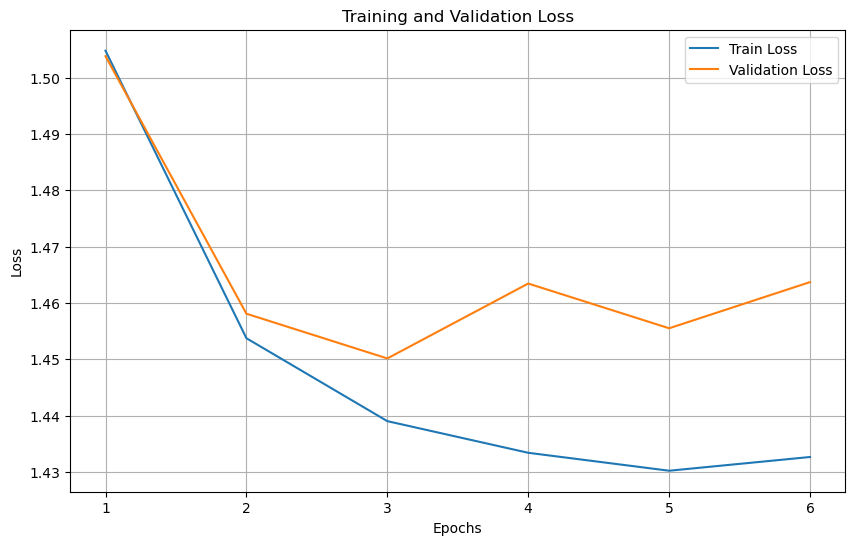

In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Testing the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Forward Pass
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Calculate Accuracy
accuracy = accuracy_score(y_test_tensor.numpy(), predicted.numpy())
print(f'Accuracy: {accuracy:.4f}')

# Calculate Precision, Recall, and F1 Score (for each class)
precision = precision_score(y_test_tensor.numpy(), predicted.numpy(), average='weighted')  # Using weighted average
recall = recall_score(y_test_tensor.numpy(), predicted.numpy(), average='weighted')        # Using weighted average
f1 = f1_score(y_test_tensor.numpy(), predicted.numpy(), average='weighted')                # Using weighted average

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.7879
Precision: 0.6766
Recall: 0.7879
F1 Score: 0.7273


/data2404/buyf/anaconda3/envs/d2l/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


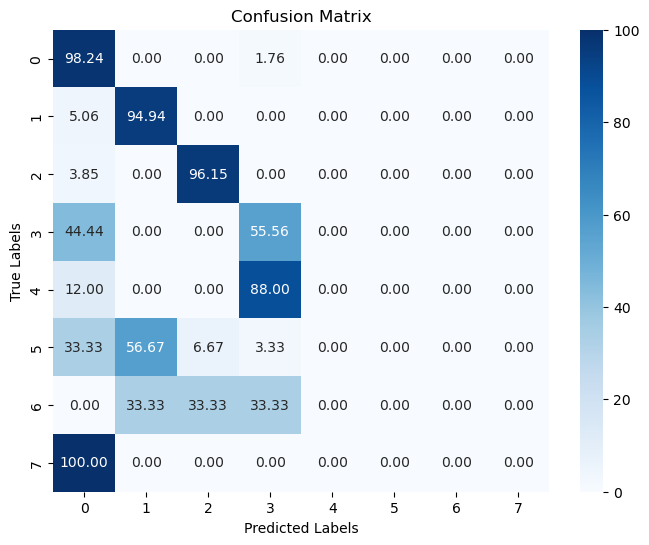

In [ ]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test_tensor.numpy(), predicted.numpy())  # Both y_test_tensor and predicted need to be converted to numpy arrays
# Convert confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.arange(cm_percentage.shape[0]), yticklabels=np.arange(cm_percentage.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Capture print(model) Output
old_stdout = sys.stdout  # Save the current stdout
sys.stdout = io.StringIO()  # Replace with StringIO object

print(model)  # Print model structure

# Get the captured content and split it into lines
model_str = sys.stdout.getvalue().splitlines()
models.append(model_str)

# Restore stdout
sys.stdout = old_stdout

In [ ]:
accuracy_list = []
precision_list =[]
F1_score_list =[]
recall_list =[]
models = []
learning_rates = []
weight_decays = []
Class = ["Basic Model","Reduced_Neuron_Model","Increased_L2_Model","Increased_Drop_out_Model","Increased_Lr_Model"]

In [ ]:
accuracy_list.append(accuracy)
precision_list.append(precision)
F1_score_list.append(f1)
recall_list.append(recall)
learning_rates.append(learning_rate)
weight_decays.append(l2_lambda)

In [ ]:
results = {
    'Class':Class,
    'Model': models,
    'Learning Rate': learning_rates,
    'Weight Decay': weight_decays,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': F1_score_list
}

results_df = pd.DataFrame(results)


In [ ]:
print(results_df)

                      Class  \
0               Basic Model   
1      Reduced_Neuron_Model   
2        Increased_L2_Model   
3  Increased_Drpo_out_Model   
4        Increased_Lr_Model   

                                               Model  Learning Rate  \
0  ['ResNetMLP(', '  (blocks): ModuleList(', '   ...          0.001   
1  ['ResNetMLP(', '  (blocks): ModuleList(', '   ...          0.001   
2  ['ResNetMLP(', '  (blocks): ModuleList(', '   ...          0.001   
3  ['ResNetMLP(', '  (blocks): ModuleList(', '   ...          0.001   
4  ['ResNetMLP(', '  (blocks): ModuleList(', '   ...          0.010   

   Weight Decay  Accuracy  Precision    Recall  F1 Score  
0          0.01  0.898990   0.889347  0.898990  0.893731  
1          0.01  0.926768   0.924055  0.926768  0.923039  
2          0.10  0.893939   0.885307  0.893939  0.887442  
3          0.01  0.934343   0.924348  0.934343  0.929043  
4          0.01  0.787879   0.676610  0.787879  0.727257  


In [ ]:
#Saved as Excel file
results_df.to_excel("results.xlsx", index=False)

## **6. ResNet-Based MLP Model Summary and Discussion**

### **6.1. Model Architecture**
The model is a Multi-Layer Perceptron (MLP) based on the ResNet architecture, consisting of multiple residual blocks (ResNetBlock). Each residual block contains two fully connected layers (Linear), each followed by batch normalization (BatchNorm1d) and ReLU activation. Additionally, each block includes a dropout layer to prevent overfitting and a shortcut connection to enhance information flow. Finally, the model maps features to 8 classes through an output layer (fc_out) and uses the softmax function for classification. During the training of the base model, the validation loss fluctuated and increased, leading to early stopping after 8 epochs when the validation loss failed to decrease three times consecutively, indicating overfitting.

### **6.2. Reducing Hidden Layer Neurons**
To address overfitting in the base model, the number of neurons in the hidden layers was reduced from `[256, 128, 64]` to `[128, 64, 32]`. This significantly reduced the training time per epoch, and both the validation loss and training loss showed a declining trend. The performance of the model improved compared to the base model. Therefore, reducing the model depth effectively prevents overfitting while enhancing model performance.

### **6.3. Increasing L2 Regularization**
The L2 regularization weight in the base model was increased from 0.01 to 0.1. Training stopped after 8 epochs, with the validation loss showing a declining trend. Increasing the L2 weight helps prevent overfitting, although its effect is less pronounced compared to reducing model depth.

### **6.4. Increasing Dropout Rate**
The dropout rate in the base model was increased from 0.1 to 0.5. Training stopped after 14 epochs, with the validation loss showing a declining trend. The dropout technique, by randomly dropping neurons, effectively reduces the model's reliance on specific neurons, thereby enhancing its generalization ability.

### **6.5. Increasing Learning Rate**
Building on model (4), the learning rate was increased from 0.001 to 0.01. Training stopped after 6 epochs, with the validation loss exhibiting significant fluctuations and an upward trend. An excessively high learning rate can cause the model to oscillate near the optimal solution of the loss function, preventing effective convergence.

### **6.6. Model Evaluation Metrics**
Based on the four commonly used evaluation metrics—Accuracy, Precision, Recall, and F1 score—the following conclusions can be drawn:

- **Increased_Drop_out_Model > Reduced_Neuron_Model > Basic_Model > Increased_L2_Model > Increased_Lr_Model**

Increasing the dropout rate and reducing the number of neurons both reduce model complexity, thereby preventing overfitting. Increasing the L2 regularization coefficient has a less noticeable effect, with the Increased_L2_Model performing similarly to the Basic_Model. On the other hand, increasing the learning rate degrades model performance.


### Key Insights
1. **Model Complexity and Overfitting**: Reducing the number of neurons and increasing the dropout rate are effective strategies for mitigating overfitting, as they reduce model complexity and enhance generalization.
2. **Regularization**: While L2 regularization helps prevent overfitting, its impact is less significant compared to architectural changes such as reducing model depth.
3. **Learning Rate**: An excessively high learning rate can destabilize training, leading to poor convergence and suboptimal model performance.
4. **Evaluation Metrics**: The use of multiple evaluation metrics (Accuracy, Precision, Recall, F1 score) provides a comprehensive understanding of model performance, highlighting the trade-offs between different regularization and architectural choices.


The ResNet-based MLP model demonstrates the importance of balancing model complexity, regularization, and learning rate to achieve optimal performance. Reducing the number of neurons and increasing the dropout rate are particularly effective strategies for preventing overfitting. However, increasing the learning rate can destabilize training, highlighting the need for careful hyperparameter tuning. Future work should focus on exploring advanced regularization techniques and alternative architectures to further enhance model performance and generalization.